## Conformal Prediction for Regression
This notebook demonstrates usage of conformal prediction for regression models using single and multiple region models. The region uncertainity estimator treats the provided base (user) model as black box model.


<a id='notebook_workflow'></a>
## Notebook Workflow
- [Imports](#imports)
- [Load Dataset](#load_dataset)
- [Plot Data](#plot_data)
- [Train Regressor](#train_classifier)
- [Initialize Conformal Prediction Using Single Region](#initialize_cp_single_region)
- [Emit A Conformal Prediction_Model](#emit_cp_sr_model)
- [Score The Conformal Prediction_Model](#score_cp_sr_model)
- [Initialize Conformal Prediction Using Multi Region](#initialize_cp_multi_region)
- [Emit A Conformal Prediction_Model](#emit_cp_mr_model)
- [Score The Conformal Prediction_Model](#score_cp_mr_model)
- [Single Region Vs Multi Region](#region_class_comparison)


<a id='imports'></a>
### Imports

In [1]:
import json
import onnx
import warnings
import numpy as np
import pandas as pd
from joblib import dump
import onnxruntime as rt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from model_trust.datasets.synthetic_data import load_linear_2_region_data
from model_trust.regression.region_uncertainty_estimation import RegionUncertaintyEstimator

warnings.filterwarnings("ignore")

### Load Dataset

In [2]:
quantile = 0.9
dataset = load_linear_2_region_data(nsamples=3000,
                                      quantile=quantile,
                                      sigma_0=1,
                                      sigma_1=4,
                                      test_ratio=0.2,
                                      cal_ratio=0.2,
                                      seed=42,)

data = dataset["data"]
features = dataset["features"]
target = dataset["target"]
X = data[features].values
Y = data[target].values

x_train = dataset["x_train"]
x_test = dataset["x_test"]
x_cal = dataset["x_cal"]

y_train = dataset["y_train"]
y_test = dataset["y_test"]
y_cal = dataset["y_cal"]


### Plot Data

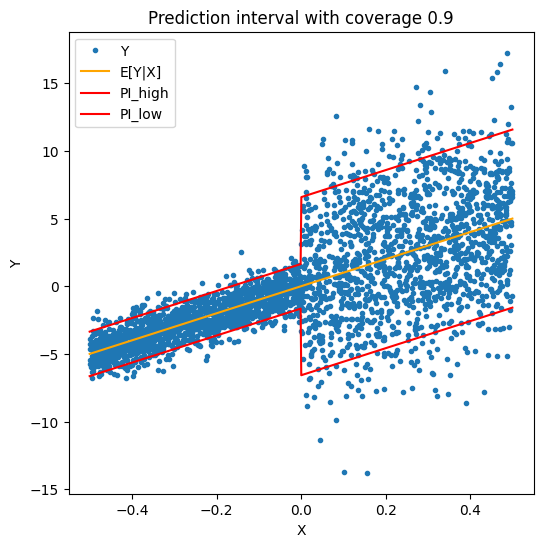

In [3]:
pi_gt_low = data["PI_GT_LOW"].values
pi_gt_high = data["PI_GT_HIGH"].values
Y_mean = data["Y_mean"].values
coverage_empirical = np.mean((Y <= pi_gt_high)& (Y >= pi_gt_low))

X_sort = np.sort(X.flatten())
X_sort_indices = np.argsort(X.flatten())

plt.figure(figsize=(6,6))
plt.plot(X, Y, ".", label="Y")
# plt.title("COVERAGE TARGET {}; EMPIRICAL : {}".format(str(quantile), str(np.round(coverage_empirical,2)))) # title ??
plt.title("Prediction interval with coverage {}".format(str(quantile)))

plt.plot(X_sort, Y_mean[X_sort_indices],  'orange', label = 'E[Y|X]')
plt.plot(X_sort, pi_gt_high[X_sort_indices], 'r', label = 'PI_high')
plt.plot(X_sort, pi_gt_low[X_sort_indices], 'r', label = 'PI_low')
plt.xlabel("X")
plt.ylabel("Y")

plt.legend()
plt.show()

Uncomment below code to upload data files to S3. Otherwise, skip to next cell.

In [4]:

# import io
# import os
# import boto3

# # s3 connection
# session = boto3.Session(
#     aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
#     aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
# )
# s3_client = session.client('s3',
#                     endpoint_url=os.getenv("AWS_ENDPOINT_URL"),
#                     region_name=os.getenv("AWS_REGION"),
# )
# base_model_bucket = "model-trust" # s3 bucket with base model

# x_train_csv_buffer = io.BytesIO()
# pd.DataFrame(x_cal, columns=features).to_csv(x_train_csv_buffer, index=False)
# x_train_csv_buffer.seek(0)
# s3_client.put_object(Body=x_train_csv_buffer, Bucket=base_model_bucket, Key="simulated_data/x_cal.csv")

### Train Regressor

In [5]:
base_model = LinearRegression().fit(x_train, y_train)
print('Train/Test R2 scores')
y_pred_cal = base_model.predict(x_cal)
y_pred = base_model.predict(x_test)
print(base_model.score(x_train, y_train), base_model.score(x_test, y_test))

Train/Test R2 scores
0.4662926288878644 0.48260603840297045


In [6]:
y_pred_cal.shape

(480,)

### Initialize Conformal Prediction using Single Region

#### Serialize original model using onnx

In [7]:
from skl2onnx import to_onnx
from skl2onnx.common.data_types import FloatTensorType

OPSET_VERSION = 17
base_onnx_model = to_onnx(
                base_model, x_train[:1].astype(np.float32),
                target_opset=OPSET_VERSION,
                # final_types=[('Y_Pred', FloatTensorType([None, 1]))],
            )
base_onnx_model_str = base_onnx_model.SerializeToString()
base_onnx_model_str

b'\x08\x08\x12\x08skl2onnx\x1a\x061.15.0"\x07ai.onnx(\x002\x00:\xb0\x01\ni\n\x01X\x12\x08variable\x1a\x0fLinearRegressor"\x0fLinearRegressor*\x16\n\x0ccoefficients=\xbcC!A\xa0\x01\x06*\x14\n\nintercepts=\x1e\xec\xdc<\xa0\x01\x06:\nai.onnx.ml\x12\x16ONNX(LinearRegression)Z\x11\n\x01X\x12\x0c\n\n\x08\x01\x12\x06\n\x00\n\x02\x08\x01b\x18\n\x08variable\x12\x0c\n\n\x08\x01\x12\x06\n\x00\n\x02\x08\x01B\x0e\n\nai.onnx.ml\x10\x01B\x04\n\x00\x10\x11'

In [8]:
with open('base_onnx_model.onnx', 'wb') as base_fp:
    base_fp.write(base_onnx_model_str)

In [9]:
sess = rt.InferenceSession(base_onnx_model_str)
sess.run(None, {"X": x_test[0:1].astype(np.float32)})[0]

array([[2.4208233]], dtype=float32)

In [10]:
single_region_cp_inputs = {}
single_region_cp_inputs['base_model'] = base_onnx_model_str
single_region_cp_inputs['confidence'] = quantile*100
single_region_cp_inputs['regions_model'] = "single_region"

# single region does not have region parameters

single_region_cp_model = RegionUncertaintyEstimator(**single_region_cp_inputs)

### Emit a Conformal Prediction Model

In [11]:
%time single_region_cp_model.fit(x_cal, y_cal)

CPU times: user 655 ms, sys: 27.2 ms, total: 683 ms
Wall time: 334 ms


In [12]:
single_region_cp_model_learned_params = single_region_cp_model.export_learned_config()

In [13]:
with open('single_region_cp_model.onnx', 'wb') as fp:
    fp.write(single_region_cp_model_learned_params['combined_model'])

### Score the Conformal Prediction Model

Prediction intervals for single instance.

In [14]:
%time single_region_cp_model.predict(x_test[0:1], y_pred[0:1])

CPU times: user 428 µs, sys: 0 ns, total: 428 µs
Wall time: 499 µs


array([[-2.44483536,  7.28648248]])

In [15]:
%time single_region_cp_model.predict(x_test[0:100], y_pred[0:100])

CPU times: user 889 µs, sys: 0 ns, total: 889 µs
Wall time: 792 µs


array([[-2.44483536e+00,  7.28648248e+00],
       [-9.19938009e+00,  5.31937752e-01],
       [-2.12518084e+00,  7.60613700e+00],
       [-5.99679509e+00,  3.73452275e+00],
       [-8.77693128e+00,  9.54386559e-01],
       [-1.03424892e+00,  8.69706892e+00],
       [-8.75016731e+00,  9.81150525e-01],
       [-8.67654060e-01,  8.86366378e+00],
       [-7.52830987e-01,  8.97848685e+00],
       [-3.34883338e+00,  6.38248446e+00],
       [-1.01894856e+00,  8.71236928e+00],
       [-4.08964839e-01,  9.32235300e+00],
       [-8.67112234e+00,  1.06019550e+00],
       [-4.95720888e+00,  4.77410897e+00],
       [-9.43574014e+00,  2.95577698e-01],
       [-7.78291606e+00,  1.94840178e+00],
       [-9.69805724e+00,  3.32606051e-02],
       [-9.44319894e+00,  2.88118901e-01],
       [-1.74431611e-01,  9.55688623e+00],
       [-9.09557878e+00,  6.35739063e-01],
       [-7.26995631e+00,  2.46136153e+00],
       [-3.92317908e+00,  5.80813876e+00],
       [-3.58738945e+00,  6.14392839e+00],
       [-7.

In [16]:
# dump((x_test[0:1], y_pred[0:1]), 'input_tuple.joblib')

In [17]:
dump((x_test[0:1].astype(np.float32), y_test[0:1]), 'input_data.joblib')

['input_data.joblib']

In [18]:
x_test[0:1].astype(np.float32).tolist()

[[0.2375083565711975]]

In [19]:
dump((x_test.astype(np.float32), y_test), 'batch_input_data.joblib')

['batch_input_data.joblib']

#### Confidence Interval Using ONNX Serialized Single Region CP Model

In [20]:
single_region_sess = rt.InferenceSession(single_region_cp_model_learned_params['combined_model'])
%time single_region_model_onnx_output = single_region_sess.run(None, {"X": x_test[0:1].astype(np.float32)})

for i, out in enumerate(single_region_sess.get_outputs()):
    print({out.name: single_region_model_onnx_output[i]})

CPU times: user 187 µs, sys: 0 ns, total: 187 µs
Wall time: 199 µs
Parser   : 178 ms
{'prediction': array([[[2.4208233]]], dtype=float32)}
{'exp_lower_pred_endpoint': array([[[-2.4448354]]], dtype=float32)}
{'exp_upper_pred_endpoint': array([[[7.286482]]], dtype=float32)}


In [21]:
%time single_region_model_onnx_output = single_region_sess.run(None, {"X": x_test[0:100].astype(np.float32)})

for i, out in enumerate(single_region_sess.get_outputs()):
    print({out.name: single_region_model_onnx_output[i][:10]})

CPU times: user 486 µs, sys: 0 ns, total: 486 µs
Wall time: 395 µs
{'prediction': array([[[ 2.4208233]],

       [[-4.333721 ]],

       [[ 2.740478 ]],

       [[-1.1311362]],

       [[-3.9112723]],

       [[ 3.83141  ]],

       [[-3.8845084]],

       [[ 3.9980047]],

       [[ 4.112828 ]],

       [[ 1.5168254]]], dtype=float32)}
{'exp_lower_pred_endpoint': array([[[-2.4448354]],

       [[-9.19938  ]],

       [[-2.1251807]],

       [[-5.9967947]],

       [[-8.776931 ]],

       [[-1.0342488]],

       [[-8.750167 ]],

       [[-0.8676541]],

       [[-0.752831 ]],

       [[-3.3488333]]], dtype=float32)}
{'exp_upper_pred_endpoint': array([[[7.286482 ]],

       [[0.5319376]],

       [[7.606137 ]],

       [[3.7345226]],

       [[0.9543865]],

       [[8.697069 ]],

       [[0.9811504]],

       [[8.863664 ]],

       [[8.978487 ]],

       [[6.3824844]]], dtype=float32)}


Prediction intervals for multiple instance.

### Initialize Conformal Prediction using Multi Region

In [22]:
multi_region_cp_inputs = {}
multi_region_cp_inputs['confidence'] = quantile*100
multi_region_cp_inputs['regions_model'] = "multi_region"
multi_region_cp_inputs['base_model'] = base_onnx_model_str

# region parameters
multi_region_cp_inputs["multi_region_model_selection_metric"] = "coverage_ratio"
multi_region_cp_inputs["multi_region_model_selection_stat"] = "min"
multi_region_cp_inputs["multi_region_min_group_size"] = 20

multi_region_cp_model = RegionUncertaintyEstimator(**multi_region_cp_inputs)

### Emit a Conformal Prediction Model

In [23]:
%time multi_region_cp_model.fit(x_cal, y_cal)

Best Params :{'min_samples_leaf': 100, 'ccp_alpha': 0.1, 'max_depth': 1, 'random_state': 42}
Best model :DecisionTreeRegressor(ccp_alpha=0.1, max_depth=1, min_samples_leaf=100,
                      random_state=42)
CPU times: user 6min 47s, sys: 1.49 s, total: 6min 49s
Wall time: 44.6 s


In [24]:
multi_region_cp_model_learned_params = multi_region_cp_model.export_learned_config()

In [25]:
with open('multi_region_cp_model.onnx', 'wb') as fp:
    fp.write(multi_region_cp_model_learned_params['combined_model'])

### Score the Conformal Prediction Model

Prediction intervals for single instance.

In [26]:
%time multi_region_cp_model.predict(x_test[0:1], y_pred[0:1])

CPU times: user 2.16 ms, sys: 2 µs, total: 2.16 ms
Wall time: 2.62 ms


array([[-4.58082584,  9.42247297]])

Prediction intervals for multiple instance.

In [27]:
%time multi_region_cp_model.predict(x_test[0:100], y_pred[0:100])

CPU times: user 2.03 ms, sys: 982 µs, total: 3.01 ms
Wall time: 3.52 ms


array([[-4.58082584,  9.42247297],
       [-6.07227363, -2.5951687 ],
       [-4.26117132,  9.74212749],
       [-2.86968863,  0.6074163 ],
       [-5.64982482, -2.1727199 ],
       [-3.17023941, 10.8330594 ],
       [-5.62306086, -2.14595593],
       [-3.00364454, 10.99965426],
       [-2.88882147, 11.11447734],
       [-5.48482386,  8.51847495],
       [-3.15493905, 10.84835976],
       [-2.54495532, 11.45834349],
       [-5.54401589, -2.06691096],
       [-1.83010242,  1.64700251],
       [-6.30863369, -2.83152876],
       [-4.6558096 , -1.17870467],
       [-6.57095078, -3.09384585],
       [-6.31609248, -2.83898756],
       [-2.3104221 , 11.69287671],
       [-5.96847232, -2.49136739],
       [-4.14284986, -0.66574493],
       [-6.05916957,  7.94412924],
       [-5.72337993,  8.27991888],
       [-2.85013582, 11.15316299],
       [-2.81845599, 11.18484281],
       [-3.1861419 , 10.81715691],
       [-3.55013382, -0.07302889],
       [-2.74373424,  0.73337069],
       [-4.25340638,

#### Confidence Interval Using ONNX Serialized Multi Region CP Model

In [28]:
multi_region_sess = rt.InferenceSession(multi_region_cp_model_learned_params['combined_model'])
%time multi_region_model_onnx_output = multi_region_sess.run(None, {"X": x_test[0:1].astype(np.float32)})

for i, out in enumerate(multi_region_sess.get_outputs()):
    print({out.name: multi_region_model_onnx_output[i]})


CPU times: user 151 µs, sys: 0 ns, total: 151 µs
Wall time: 162 µs
{'input_x': array([[0.23750836]], dtype=float32)}
{'prediction': array([[2.4208233]], dtype=float32)}
{'region_model_prediction': array([[6.4995904]], dtype=float32)}
{'exp_lower_pred_endpoint': array([[-4.580826]], dtype=float32)}
{'exp_upper_pred_endpoint': array([[9.422473]], dtype=float32)}


In [29]:
%time multi_region_model_onnx_output = multi_region_sess.run(None, {"X": x_test[0:100].astype(np.float32)})

for i, out in enumerate(multi_region_sess.get_outputs()):
    print({out.name: multi_region_model_onnx_output[i][:10]})

CPU times: user 21.5 ms, sys: 959 µs, total: 22.5 ms
Wall time: 21.2 ms
{'input_x': array([[ 0.23750836],
       [-0.4326494 ],
       [ 0.26922315],
       [-0.11490227],
       [-0.39073578],
       [ 0.37746087],
       [-0.3880804 ],
       [ 0.3939897 ],
       [ 0.40538198],
       [ 0.14781745]], dtype=float32)}
{'prediction': array([[ 2.4208233],
       [-4.333721 ],
       [ 2.740478 ],
       [-1.1311362],
       [-3.9112723],
       [ 3.83141  ],
       [-3.8845084],
       [ 3.9980047],
       [ 4.112828 ],
       [ 1.5168254]], dtype=float32)}
{'region_model_prediction': array([[6.4995904],
       [1.7312058],
       [6.4995904],
       [1.7312058],
       [1.7312058],
       [6.4995904],
       [1.7312058],
       [6.4995904],
       [6.4995904],
       [6.4995904]], dtype=float32)}
{'exp_lower_pred_endpoint': array([[-4.580826 ],
       [-6.0722737],
       [-4.2611713],
       [-2.8696885],
       [-5.6498246],
       [-3.1702394],
       [-5.6230607],
       [-3.003644

### Single Region Vs Multi Region Using ONNX Model

In [30]:
x_test_sort_indices = np.argsort(x_test.flatten())
single_region_model_onnx_output = single_region_sess.run(None, {"X": x_test[x_test_sort_indices].astype(np.float32)})
multi_region_model_onnx_output = multi_region_sess.run(None, {"X": x_test[x_test_sort_indices].astype(np.float32)})

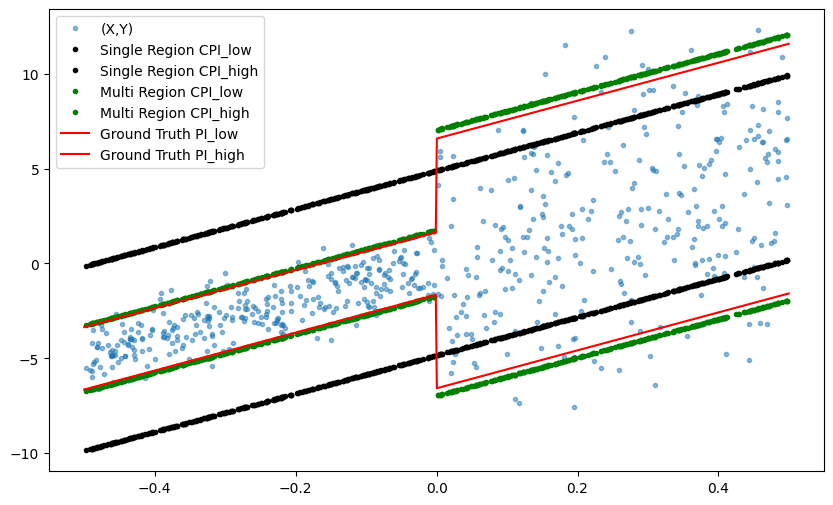

In [31]:
X_sort = np.sort(X.flatten())
X_sort_indices = np.argsort(X.flatten())

x_test_sort = np.sort(x_test.flatten())
x_test_sort_indices = np.argsort(x_test.flatten())

pi_gt_low = data["PI_GT_LOW"].values
pi_gt_high = data["PI_GT_HIGH"].values

plt.rcParams["figure.figsize"] = (10, 6)

plt.plot(x_test_sort, y_test[x_test_sort_indices], '.', alpha = 0.5, label='(X,Y)')
plt.plot(x_test_sort, single_region_model_onnx_output[-2][:, 0], 'k.', label = 'Single Region CPI_low')
plt.plot(x_test_sort, single_region_model_onnx_output[-1][:, 0], 'k.', label = 'Single Region CPI_high')

plt.plot(x_test_sort, multi_region_model_onnx_output[-2][:, 0], 'g.', label = 'Multi Region CPI_low')
plt.plot(x_test_sort, multi_region_model_onnx_output[-1][:, 0], 'g.', label = 'Multi Region CPI_high')

plt.plot(X_sort, pi_gt_low[X_sort_indices], 'r', label = 'Ground Truth PI_low')
plt.plot(X_sort, pi_gt_high[X_sort_indices], 'r', label = 'Ground Truth PI_high')

plt.legend(loc='upper left', bbox_to_anchor=(0, 1.0))
plt.show()

### Single Region Vs Multi Region Using Python Model

In [32]:
x_test_sort_indices = np.argsort(x_test.flatten())
y_pred_single_region = single_region_cp_model.predict(x_test[x_test_sort_indices],y_pred[x_test_sort_indices])
y_pred_multi_region = multi_region_cp_model.predict(x_test[x_test_sort_indices],y_pred[x_test_sort_indices])

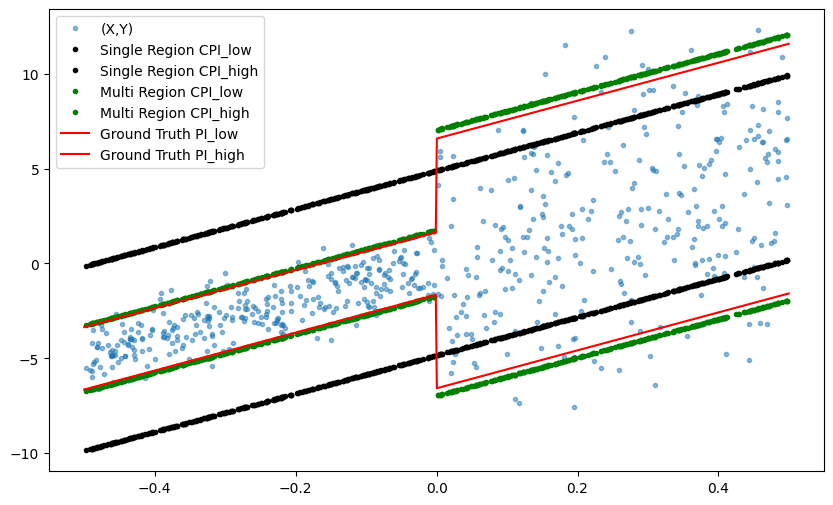

In [33]:
X_sort = np.sort(X.flatten())
X_sort_indices = np.argsort(X.flatten())

x_test_sort = np.sort(x_test.flatten())
x_test_sort_indices = np.argsort(x_test.flatten())

pi_gt_low = data["PI_GT_LOW"].values
pi_gt_high = data["PI_GT_HIGH"].values

plt.rcParams["figure.figsize"] = (10, 6)

plt.plot(x_test_sort, y_test[x_test_sort_indices], '.', alpha = 0.5, label='(X,Y)')
plt.plot(x_test_sort, y_pred_single_region[:, 0], 'k.', label = 'Single Region CPI_low')
plt.plot(x_test_sort, y_pred_single_region[:, 1], 'k.', label = 'Single Region CPI_high')

plt.plot(x_test_sort, y_pred_multi_region[:, 0], 'g.', label = 'Multi Region CPI_low')
plt.plot(x_test_sort, y_pred_multi_region[:, 1], 'g.', label = 'Multi Region CPI_high')

plt.plot(X_sort, pi_gt_low[X_sort_indices], 'r', label = 'Ground Truth PI_low')
plt.plot(X_sort, pi_gt_high[X_sort_indices], 'r', label = 'Ground Truth PI_high')

plt.legend(loc='upper left', bbox_to_anchor=(0, 1.0))
plt.show()